In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Vertex AI Matching Engine for Text-to-Image Embeddings
![ ](https://www.google-analytics.com/collect?v=2&tid=G-L6X3ECH596&cid=1&en=page_view&sid=1&dt=sdk_matching_engine_create_multimodal_embeddings.ipynb&dl=notebooks%2Fofficial%2Fmatching_engine%2Fsdk_matching_engine_create_multimodal_embeddings.ipynb)
<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/matching_engine/sdk_matching_engine_create_multimodal_embeddings.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/matching_engine/sdk_matching_engine_create_multimodal_embeddings.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
      <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/matching_engine/sdk_matching_engine_create_multimodal_embeddings.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This example demonstrates how to create text-to-image embeddings using the DiffusionDB dataset and the Vertex AI Multimodal Embeddings model. These are uploaded to the Vertex AI Matching Engine service, which is a high scale, low latency solution to find similar vectors for a large corpus. Moreover, it is a fully managed offering, further reducing operational overhead. It is built upon [Approximate Nearest Neighbor (ANN) technology](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html) developed by Google Research.

Learn more about [Vertex AI Multimodal Embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-multimodal-embeddings#supported_models).
Learn more about [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview).

### Objective

In this notebook, you learn how to encode custom text embeddings, create an  Approximate Nearest Neighbor (ANN) index, and query against indexes.

This tutorial uses the following Google Cloud ML services:

- `Vertex AI Multimodal Embeddings`
- `Vertex AI Matching Engine`
- `Memorystore`

The steps performed include:

* Convert an image dataset to embeddings
* Create an index
* Upload embeddings to the index
* Create an index endpoint
* Deploy the index to the index endpoint
* Create a Memorystore instance to store metadata
* Perform an online query

### Dataset

The dataset used for this tutorial is the [DiffusionDB dataset](https://github.com/poloclub/diffusiondb).

> DiffusionDB is the first large-scale text-to-image prompt dataset. It contains 14 million images generated by Stable Diffusion using prompts and hyperparameters specified by real users. The unprecedented scale and diversity of this human-actuated dataset provide exciting research opportunities in understanding the interplay between prompts and generative models, detecting deepfakes, and designing human-AI interaction tools to help users more easily use these models.

## Installation

Install the latest version of Cloud Storage and the Vertex AI SDK for Python.

In [ ]:
# Install the packages
! pip3 install --upgrade google-cloud-aiplatform \
                        google-cloud-storage --upgrade

Install the latest version of google-cloud-vision for filtering for safe images

In [ ]:
# Install the packages
! pip install google-cloud-vision

### Colab only: Uncomment the following cell to restart the kernel.

In [4]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin
#### Set your project ID

If you don't know your project ID, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [2]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [3]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [4]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [5]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

* Authentication: Rerun the `gcloud auth login` command in the Vertex AI Workbench notebook terminal when you are logged out and need the credential again.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [7]:
BUCKET_URI = "gs://your-bucket-name-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

## Prepare the data

You will use [DiffusionDB dataset](https://github.com/poloclub/diffusiondb) of image prompt and image pairs.

### Clone the DiffusionDB repo

In [ ]:
! git clone https://github.com/poloclub/diffusiondb

### Install the dependencies for downloading the dataset

In [ ]:
! pip install -r diffusiondb/requirements.txt

### Download image files

In [11]:
# Download image files from 1 to 5. Each file is 1000 images.
! python diffusiondb/scripts/download.py -i 1 -r 5

### Extract image archives

In [ ]:
# Unzip all image files
image_directory = "extracted"

! unzip -n 'images/*.zip' -d '{image_directory}'

### Load image metadata

In [13]:
import json
import os

metadatas = {}
for file_name in os.listdir(image_directory):
    if file_name.endswith(".json"):
        with open(os.path.join(image_directory, file_name)) as f:
            metadata = json.load(f)
            metadatas.update(metadata)

image_names = list(metadatas.keys())
image_paths = [os.path.join(image_directory, image_name) for image_name in image_names]

len(metadatas)

4000

### Define function to detect explicit images

Define a function to query the Cloud Vision API to detect potential explicit images.

Learn more about [Detect explicit content](https://cloud.google.com/vision/docs/detecting-safe-search).

In [14]:
from typing import Optional

from google.cloud import vision
from google.cloud.vision_v1.types.image_annotator import SafeSearchAnnotation

client = vision.ImageAnnotatorClient()


def detect_safe_search(path: str) -> Optional[SafeSearchAnnotation]:
    """Detects unsafe features in the file."""

    with open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.safe_search_detection(image=image)

    if response.error.message:
        print(response.error.message)
        return None

    return response.safe_search_annotation

### Define safe search annotation conversion to boolean values
Define a function to convert safe search annotation results to a boolean value.

In [15]:
from google.cloud.vision_v1.types.image_annotator import Likelihood


# Returns true if some annotations have a potential safety issues
def convert_annotation_to_safety(safe_search_annotation: SafeSearchAnnotation) -> bool:
    return all(
        [
            (safe_level == Likelihood.VERY_UNLIKELY)
            or (safe_level == Likelihood.UNLIKELY)
            for safe_level in [
                safe_search_annotation.adult,
                safe_search_annotation.medical,
                safe_search_annotation.violence,
                safe_search_annotation.racy,
            ]
        ]
    )

### Perform rate-limited explicit image detection

Google Cloud Vision has a rate limit for API requests.

Use a rate limiter to ensure the requests go under this limit.
For better performance, use a ThreadPool to make parallel requests. This is out-of-scope for this notebook.

Learn more about [Quotas and Limits](https://cloud.google.com/vision/quotas?hl=en).

In [16]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Optional

import numpy as np
from tqdm import tqdm

# Create a rate limiter with a limit of 1800 requests per minute
seconds_per_job = 1 / (1800 / 60)


def process_image(image_path: str) -> Optional[bool]:
    try:
        annotation = detect_safe_search(image_path)

        if annotation:
            return convert_annotation_to_safety(safe_search_annotation=annotation)
        else:
            return None
    except Exception:
        return None


# Process images using ThreadPool
is_safe_values_cloud_vision = []
with ThreadPoolExecutor() as executor:
    futures = []
    for img_url in tqdm(image_paths, total=len(image_paths), position=0):
        futures.append(executor.submit(process_image, img_url))
        time.sleep(seconds_per_job)

    for future in futures:
        is_safe_values_cloud_vision.append(future.result())

# Set Nones to False
is_safe_values_cloud_vision = [
    is_safe or False for is_safe in is_safe_values_cloud_vision
]

# Print number of safe images found
print(
    f"Safe images = {np.array(is_safe_values_cloud_vision).sum()} out of {len(is_safe_values_cloud_vision)} images"
)

100%|██████████| 4000/4000 [02:14<00:00, 29.69it/s]


Safe images = 3292 out of 4000 images


In [27]:
# Filter images by safety
metadatas = [
    metadata
    for metadata, is_safe in zip(metadatas, is_safe_values_cloud_vision)
    if is_safe
]
image_names = [
    image_name
    for image_name, is_safe in zip(image_names, is_safe_values_cloud_vision)
    if is_safe
]
image_paths = [
    image_path
    for image_path, is_safe in zip(image_paths, is_safe_values_cloud_vision)
    if is_safe
]

#### Defining encoding functions

Create an EmbeddingPredictionClient which encapsulates the logic to call the embedding API.

In [28]:
import base64
import time
import typing

from google.cloud import aiplatform
from google.protobuf import struct_pb2


class EmbeddingResponse(typing.NamedTuple):
    text_embedding: typing.Sequence[float]
    image_embedding: typing.Sequence[float]


def load_image_bytes(image_uri: str) -> bytes:
    """Load image bytes from a remote or local URI."""
    image_bytes = None
    if image_uri.startswith("http://") or image_uri.startswith("https://"):
        response = requests.get(image_uri, stream=True)
        if response.status_code == 200:
            image_bytes = response.content
    else:
        image_bytes = open(image_uri, "rb").read()
    return image_bytes


class EmbeddingPredictionClient:
    """Wrapper around Prediction Service Client."""

    def __init__(
        self,
        project: str,
        location: str = "us-central1",
        api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com",
    ):
        client_options = {"api_endpoint": api_regional_endpoint}
        # Initialize client that will be used to create and send requests.
        # This client only needs to be created once, and can be reused for multiple requests.
        self.client = aiplatform.gapic.PredictionServiceClient(
            client_options=client_options
        )
        self.location = location
        self.project = project

    def get_embedding(self, text: str = None, image_file: str = None):
        if not text and not image_file:
            raise ValueError("At least one of text or image_file must be specified.")

        # Load image file
        image_bytes = None
        if image_file:
            image_bytes = load_image_bytes(image_file)

        instance = struct_pb2.Struct()
        if text:
            instance.fields["text"].string_value = text

        if image_bytes:
            encoded_content = base64.b64encode(image_bytes).decode("utf-8")
            image_struct = instance.fields["image"].struct_value
            image_struct.fields["bytesBase64Encoded"].string_value = encoded_content

        instances = [instance]
        endpoint = (
            f"projects/{self.project}/locations/{self.location}"
            "/publishers/google/models/multimodalembedding@001"
        )
        response = self.client.predict(endpoint=endpoint, instances=instances)

        text_embedding = None
        if text:
            text_emb_value = response.predictions[0]["textEmbedding"]
            text_embedding = [v for v in text_emb_value]

        image_embedding = None
        if image_bytes:
            image_emb_value = response.predictions[0]["imageEmbedding"]
            image_embedding = [v for v in image_emb_value]

        return EmbeddingResponse(
            text_embedding=text_embedding, image_embedding=image_embedding
        )

#### Create helper functions to process data in batches

In [ ]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Callable, Generator, List

from tqdm.auto import tqdm


def generate_batches(
    inputs: List[str], batch_size: int
) -> Generator[List[str], None, None]:
    """
    Generator function that takes a list of strings and a batch size, and yields batches of the specified size.
    """

    for i in range(0, len(inputs), batch_size):
        yield inputs[i : i + batch_size]


API_IMAGES_PER_SECOND = 2


def encode_to_embeddings_chunked(
    process_function: Callable[[List[str]], List[Optional[List[float]]]],
    items: List[str],
    batch_size: int = 1,
) -> List[Optional[List[float]]]:
    """
    Function that encodes a list of strings into embeddings using a process function.
    It takes a list of strings and returns a list of optional lists of floats.
    The data is processed in chunks to prevent out-of-memory errors.
    """

    embeddings_list: List[Optional[List[float]]] = []

    # Prepare the batches using a generator
    batches = generate_batches(items, batch_size)

    seconds_per_job = batch_size / API_IMAGES_PER_SECOND

    with ThreadPoolExecutor() as executor:
        futures = []
        for batch in tqdm(batches, total=len(items) // batch_size, position=0):
            futures.append(executor.submit(process_function, batch))
            time.sleep(seconds_per_job)

        for future in futures:
            embeddings_list.extend(future.result())
    return embeddings_list

#### Create functions that wrap embedding functions in try-except and retry logic.

This particular embedding model can only process 1 image at a time, so inputs are validated to be equal to a length of 1.

In [51]:
import copy
from typing import List, Optional

import numpy as np
import requests
from tenacity import retry, stop_after_attempt

client = EmbeddingPredictionClient(project=PROJECT_ID)


# Use a retry handler in case of failure
@retry(reraise=True, stop=stop_after_attempt(3))
def encode_texts_to_embeddings_with_retry(text: List[str]) -> List[List[float]]:
    assert len(text) == 1

    try:
        return [client.get_embedding(text=text[0], image_file=None).text_embedding]
    except Exception:
        raise RuntimeError("Error getting embedding.")


def encode_texts_to_embeddings(text: List[str]) -> List[Optional[List[float]]]:
    try:
        return encode_texts_to_embeddings_with_retry(text=text)
    except Exception:
        return [None for _ in range(len(text))]


@retry(reraise=True, stop=stop_after_attempt(3))
def encode_images_to_embeddings_with_retry(image_uris: List[str]) -> List[List[float]]:
    assert len(image_uris) == 1

    try:
        return [
            client.get_embedding(text=None, image_file=image_uris[0]).image_embedding
        ]
    except Exception as ex:
        print(ex)
        raise RuntimeError("Error getting embedding.")


def encode_images_to_embeddings(image_uris: List[str]) -> List[Optional[List[float]]]:
    try:
        return encode_images_to_embeddings_with_retry(image_uris=image_uris)
    except Exception as ex:
        print(ex)
        return [None for _ in range(len(image_uris))]

#### Test the encoding function

Encode a subset of data and see if the embeddings and distance metrics make sense.

Since there is no public paper describing the embedding model, assume that the embeddings are trained using cosine similarity as a loss function since that is quite common.

In [31]:
%%time
# Encode a sample subset of images
image_paths_filtered = list(image_paths)[:1000]
image_embeddings = encode_to_embeddings_chunked(
    process_function=encode_images_to_embeddings, items=image_paths_filtered
)

# Keep only non-None embeddings
indexes_to_keep, image_embeddings = zip(
    *[
        (index, embedding)
        for index, embedding in enumerate(image_embeddings)
        if embedding is not None
    ]
)

print(f"Processed {len(indexes_to_keep)} embeddings successfully")

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 6.99 s, sys: 1.41 s, total: 8.4 s
Wall time: 1min 52s


1000

In [ ]:
import numpy as np


def dot_product_distance(
    text_embedding: np.ndarray, image_embeddings: np.ndarray
) -> np.ndarray:
    """Compute dot-product distance between text and image embeddings by taking the dot product"""
    return np.dot(text_embedding, image_embeddings.T)

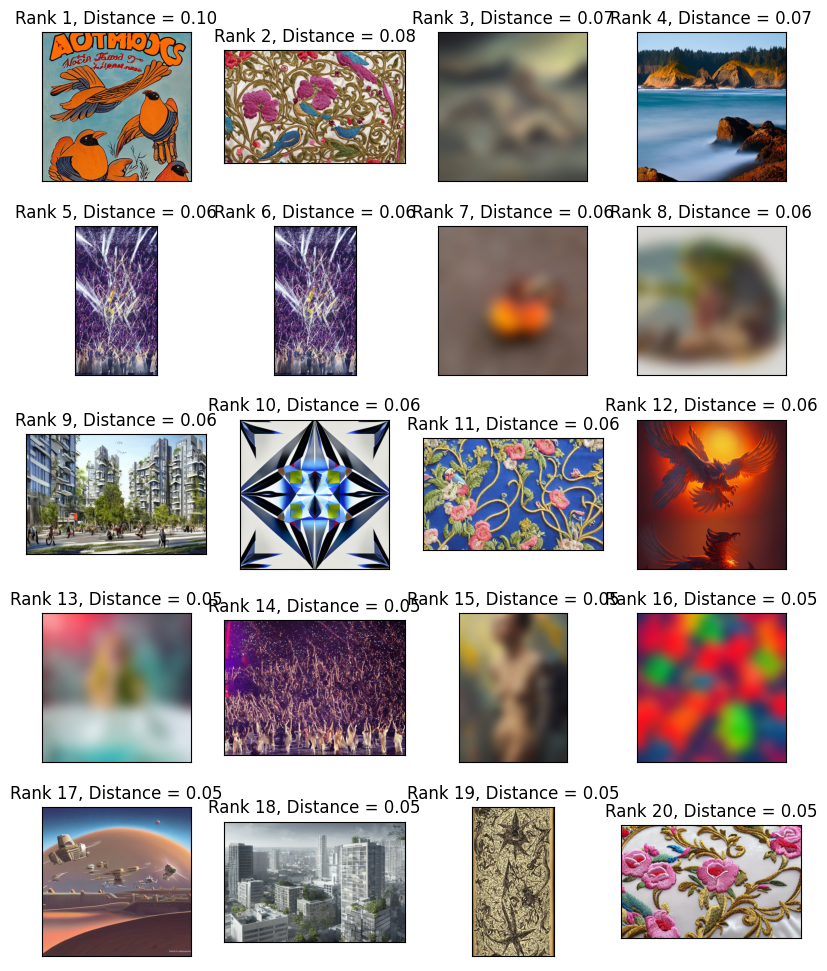

In [33]:
import math
from io import BytesIO

import matplotlib.pyplot as plt
from PIL import Image

text_query = "Birds in flight"

# Calculate text embedding of query
text_embedding = encode_texts_to_embeddings(text=[text_query])[0]

# Calculate distance
distances = dot_product_distance(
    text_embedding=np.array(text_embedding), image_embeddings=np.array(image_embeddings)
)

# Set the maximum number of images to display
MAX_IMAGES = 20

# Sort images and scores by descending order of scores and select the top max_images
sorted_data = sorted(
    zip(image_paths_filtered, distances), key=lambda x: x[1], reverse=True
)[:MAX_IMAGES]

# Calculate the number of rows and columns needed to display the images
num_cols = 4
num_rows = math.ceil(len(sorted_data) / num_cols)


# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, (image_path, distance) in enumerate(sorted_data):
    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Check if image_path is a remote URL
    if image_path.startswith("http://") or image_path.startswith("https://"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)

    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Rank {i+1}, Distance = {distance:.2f}")

    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

Save the dimension size for later usage when creating the index.

In [40]:
DIMENSIONS = len(text_embedding)

DIMENSIONS

1408

#### Save the embeddings in JSONL format

The data must be formatted in JSONL format, which means each embedding dictionary is written as an individual JSON object on its own line.

See more information in the docs at [Input data format and structure](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/format-structure#data-file-formats).

In [35]:
import tempfile

# Create temporary file to write embeddings to
embeddings_file = tempfile.NamedTemporaryFile(suffix=".json", delete=False)

embeddings_file.name

'/var/tmp/tmpkzit92f2.json'

In [ ]:
import json

BATCH_SIZE = 1000

with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(image_names), BATCH_SIZE)):
        image_names_chunk = image_names[i : i + BATCH_SIZE]
        image_paths_chunk = image_paths[i : i + BATCH_SIZE]

        embeddings = encode_to_embeddings_chunked(
            process_function=encode_images_to_embeddings, items=image_paths_chunk
        )

        # Append to file
        embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id),
                    "embedding": [str(value) for value in embedding],
                }
            )
            + "\n"
            for id, embedding in zip(image_names_chunk, embeddings)
            if embedding is not None
        ]
        f.writelines(embeddings_formatted)

Upload the training data to GCS.

In [ ]:
UNIQUE_FOLDER_NAME = "embeddings_folder_unique"
EMBEDDINGS_INITIAL_URI = f"{BUCKET_URI}/{UNIQUE_FOLDER_NAME}/"
! gsutil cp {embeddings_file.name} {EMBEDDINGS_INITIAL_URI}

## Create Indexes


### Create ANN Index (for Production Usage)

In [42]:
DISPLAY_NAME = "multimodal_diffusiondb"
DESCRIPTION = "Multimodal DiffusionDB Embeddings"

In [43]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

#### Create the index configuration

For information on configuration settings, see the [Manage Indexes documentation](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index)

In [ ]:
tree_ah_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name=DISPLAY_NAME,
    contents_delta_uri=EMBEDDINGS_INITIAL_URI,
    dimensions=DIMENSIONS,
    approximate_neighbors_count=150,
    distance_measure_type="COSINE_DISTANCE",
    leaf_node_embedding_count=500,
    leaf_nodes_to_search_percent=7,
    description=DESCRIPTION,
)

In [ ]:
INDEX_RESOURCE_NAME = tree_ah_index.resource_name
INDEX_RESOURCE_NAME

Using the resource name, you can retrieve an existing MatchingEngineIndex.

In [ ]:
tree_ah_index = aiplatform.MatchingEngineIndex(index_name=INDEX_RESOURCE_NAME)

## Create an IndexEndpoint

In [ ]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DISPLAY_NAME,
    description=DISPLAY_NAME,
    public_endpoint_enabled=True,
)

## Deploy Indexes

### Deploy ANN Index

In [ ]:
DEPLOYED_INDEX_ID = "deployed_index_id_unique"

In [ ]:
my_index_endpoint = my_index_endpoint.deploy_index(
    index=tree_ah_index, deployed_index_id=DEPLOYED_INDEX_ID
)

my_index_endpoint.deployed_indexes

## Create Online Queries

After you built your indexes, you may query against the deployed index to find nearest neighbors.

In [53]:
# Encode query
text_embeddings = encode_texts_to_embeddings(text=["New York skyline"])

In [54]:
# Define number of neighbors to return
NUM_NEIGHBORS = 20

response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=text_embeddings,
    num_neighbors=NUM_NEIGHBORS,
)

response

[[MatchNeighbor(id='40d7df76-5413-4948-9a19-6360f9461390.png', distance=0.8957392573356628),
  MatchNeighbor(id='f31deabd-b18f-43ae-a336-dfe7a74f521c.png', distance=0.9005841016769409),
  MatchNeighbor(id='9d990860-cc36-400c-b414-ea7a6257bff8.png', distance=0.9158724546432495),
  MatchNeighbor(id='6ba4dfe8-e163-4264-971a-257d12facb7c.png', distance=0.919234037399292),
  MatchNeighbor(id='2ece928d-264b-4283-ae86-78be08b27820.png', distance=0.9204674363136292),
  MatchNeighbor(id='b5e3502d-0b1d-4362-b14e-c09c84ff0238.png', distance=0.9226469993591309),
  MatchNeighbor(id='9c96ecbe-a749-4c47-bd30-8853606c3c87.png', distance=0.9258934259414673),
  MatchNeighbor(id='e7f5f1a7-88d1-4ab3-83b8-f02d50e5d564.png', distance=0.9260851144790649),
  MatchNeighbor(id='21c6313b-55bd-4e83-8fab-751d901a8855.png', distance=0.9280754327774048),
  MatchNeighbor(id='bb0b2d6b-8b74-4f0e-88be-fc8dc3d6ff9e.png', distance=0.9368126392364502),
  MatchNeighbor(id='4e4c32d0-70ba-4491-8adb-e0d46a92e3b0.png', distance

Plot the response and verify that images match the text query

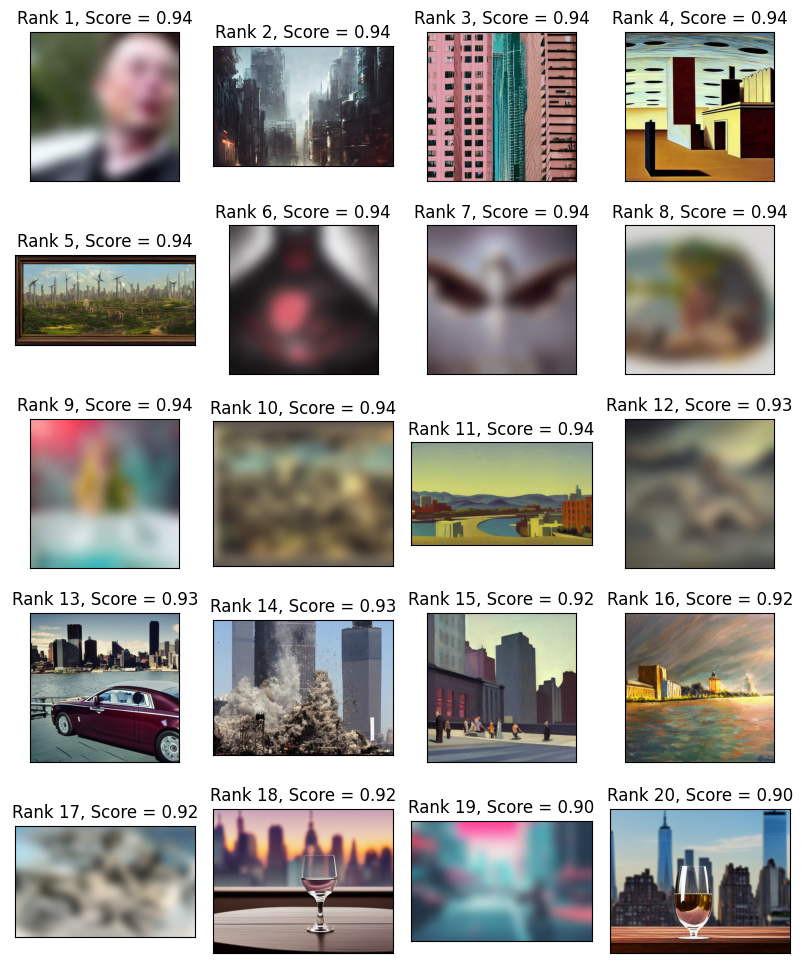

In [55]:
# Sort images and scores by descending order of scores and select the top max_images
sorted_data = sorted(response[0], key=lambda x: x.distance, reverse=True)

# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, response in enumerate(sorted_data):
    image_path = f"{image_directory}/{response.id}"
    score = response.distance

    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Display the image in the current subplot
    if os.path.exists(image_path):
        image = copy.deepcopy(Image.open(image_path))
        axs[row_idx, col_idx].imshow(image, cmap="gray")

        # Set the title of the subplot to the image index and score
        axs[row_idx, col_idx].set_title(f"Rank {i+1}, Score = {score:.2f}")

        # Remove ticks from the subplot
        axs[row_idx, col_idx].set_xticks([])
        axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.
You can also manually delete resources that you created by running the following code.

In [ ]:
# Force undeployment of indexes and delete endpoint
my_index_endpoint.delete(force=True)

In [ ]:
# Delete indexes
tree_ah_index.delete()